#  Исследование маркетинговой успешности компьютерных игр

Заказчиком представленны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить ключевый факторы и закономерности определяющие успешность игры. Нужно выявить параметры позволяющие определять потенциально популярный продукт и для эффективного планирования рекламных кампаний.
Обработаем данные за представленный исторический период, до 2016 года и ответим на вопрос какие игры будут популярны в дальнейшем. 

### Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [7]:
display(df.sample(5))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
2669,Dragon Ball: Raging Blast,PS3,2009.0,Fighting,0.37,0.19,0.11,0.10,57.0,7.2,T
1102,NBA Ballers,PS2,2004.0,Sports,0.81,0.63,0.00,0.21,83.0,9.2,E
7420,Threads of Fate,PS,1999.0,Role-Playing,0.12,0.08,0.00,0.01,NaN,NaN,NaN
11235,F.E.A.R. Files,X360,2007.0,Shooter,0.07,0.01,0.00,0.01,66.0,7.1,M
13796,North American Hunting Extravaganza 2,Wii,2010.0,Sports,0.03,0.00,0.00,0.00,NaN,NaN,NaN


В результате анализа имеющихся данных, обнаружены следующие проблемы:
- Обнаружены пропуски в столбцах Year_of_Release, Critic_Score, User_Score, Rating, Name, Genre. Заполним их. 
Пропуски в столбцах Name и Genre связаны здесь пристутсвуют две игры по которым почти полностью отсутствуют данные, удалим эти две строки и пропуски в данных столбцах исчезнут. В столбце Year_of_Release обнаружено 269 пропусков, что составляет меньше двух процентов от общего массива данных, так как в имеющихся данных недостаточно информации для заполнения пропусков и потеря этих данных не повляет на качество последующего исследования, уберем все строки в которых обнаружены пропуски.
- В названии столбцов присутствуют символы в верхнем регистре, приведем их к нижнему регистру.
- Столбцы Year_of_Release, Critic_Score имеют тип данных float64, можно привести их к целым значениям изменив тип данных на int64
- В столбце user_score присутствуют значения tbd, что может значить To Be Determined - будет определенно позже или будет удалено


### Шаг 2. Подготовим данные

In [8]:
# Приведем названия столбцов к нижнем регистру
df.set_axis(['name', 'platform', 'year_of_release','genre','na_sales','eu_sales','jp_sales','other_sales',
             'critic_score', 'user_score', 'rating'], axis='columns', inplace=True)

In [9]:
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [10]:
# Уберем пропуски в столбцах name и year_of_release
df = df[df['name'].notna()]
df = df[df['year_of_release'].notna()]

In [11]:
# Проверяем, пропуски устранены
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

In [12]:
# Приведем тип данных года выпуска игры к целому значению
df['year_of_release'] = df['year_of_release'].astype('int')

In [13]:
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [14]:
# Создадим столбец с общими продажами суммировав продажи в остальных регионах
df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [15]:
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Шаг 3. Проведем исследовательский анализ данных

#### Шаг 3.1 

Посмотрим, сколько игр выпускалось в разные годы. Определим важны ли данные за все периоды?

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


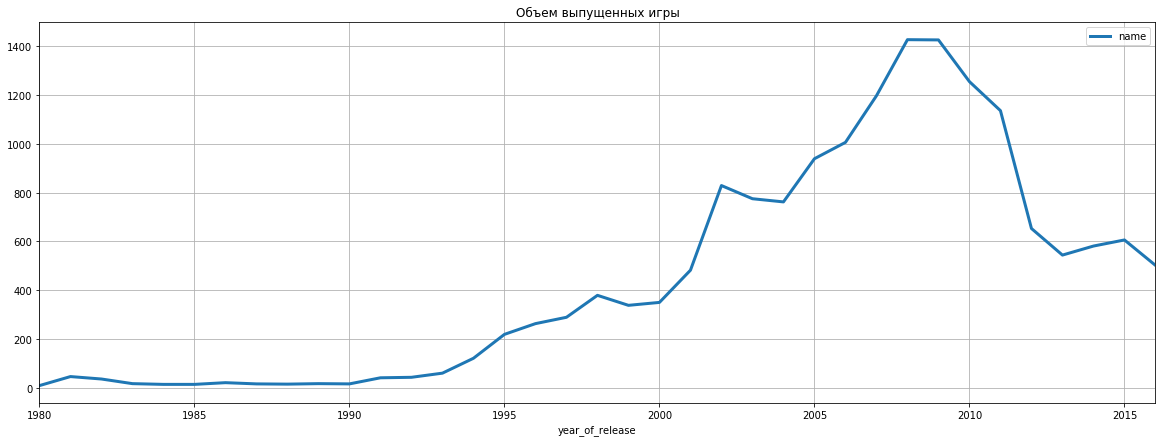

In [16]:
df_release_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count')
display(df_release_year.head(15))
df_release_year.plot(figsize=(20, 7), grid=True, 
                    linewidth=3, title='Объем выпущенных игры')

До 1994 года выпускалось меньше 100 игр в год, что является незначительным по сравнению с объемом выпуска игр в последующие годы соответсвтенно можно продолжить рассматривать только данные об играх выпущенных псоле 1994 года 

## <span style="color:orange">Что можно улучшить<span>
Для подтверждения комментария отличным решением был бы график

In [17]:
df = df.query('year_of_release >= 1994')

#### Шаг 3.2 

Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами и построим распределение по годам. Ответим на вопрос за какой характерный срок появляются новые и исчезают старые платформы?

In [18]:
df_platform = df.pivot_table(index=['platform'], values='all_sales', aggfunc='sum')

In [19]:
df_platform = df_platform.sort_values(by = 'all_sales', ascending = False)
display(df_platform.head(7))

,all_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14


Возьмем для анализа шесть самых популярных за все время платформ - PS2, X360, PS3, Wii, DS, PS

In [20]:
platforms = ["PS2", "X360", "PS3", "Wii", "DS", "PS"]

In [21]:
df_platform = df.query('platform == @platforms')
df_platform = df_platform.pivot_table(index=['platform', 'year_of_release'], values='all_sales', aggfunc='sum')

display(df_platform)

all_sales
platform year_of_release           
DS       2004                 17.27
         2005                130.14
         2006                119.81
         2007                146.94
         2008                145.31
...                             ...
X360     2012                 99.74
         2013                 88.58
         2014                 34.74
         2015                 11.96
         2016                  1.52

[66 rows x 1 columns]

In [22]:
df_platform = df_platform.sort_values(by = 'year_of_release')

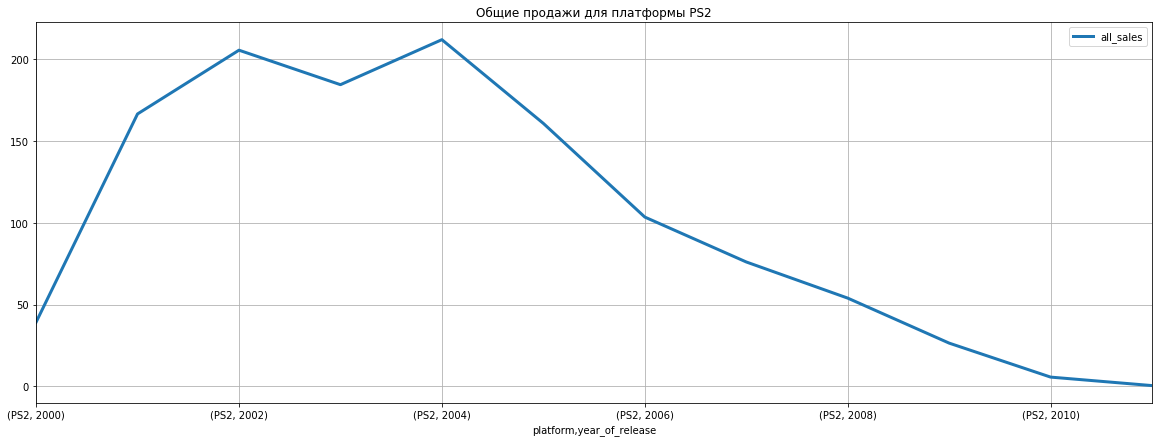

In [23]:
df_platform.query('platform == "PS2"').plot(figsize=(20, 7), grid=True, 
                                            linewidth=3, title='Общие продажи для платформы PS2')

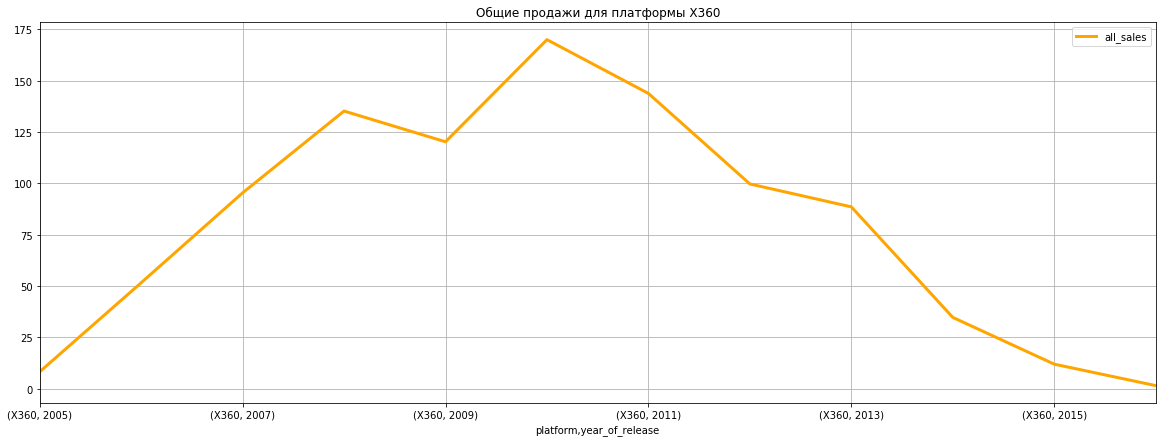

In [24]:
df_platform.query('platform == "X360"').plot(figsize=(20, 7), grid=True, color="orange",
                                            linewidth=3, title='Общие продажи для платформы X360')

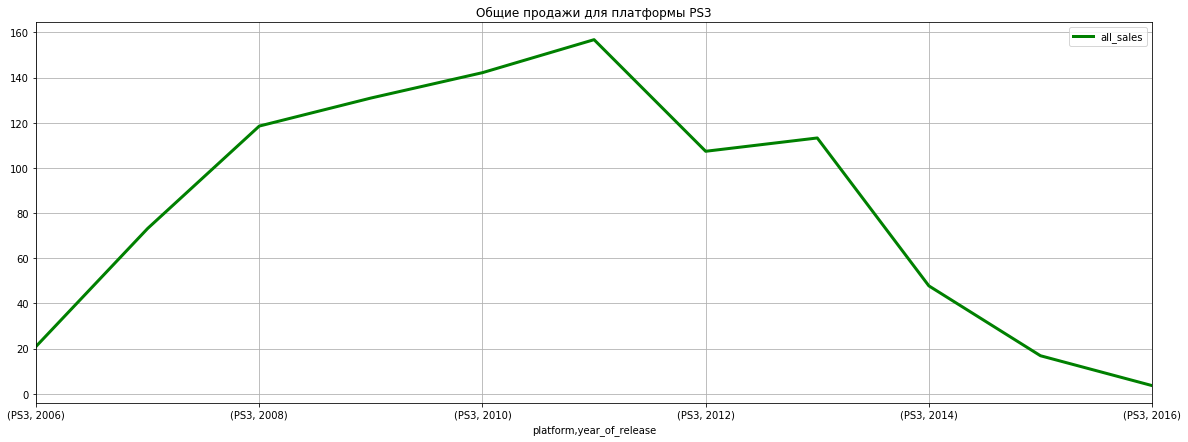

In [25]:
df_platform.query('platform == "PS3"').plot(figsize=(20, 7), grid=True, color="green", 
                                           linewidth=3, title='Общие продажи для платформы PS3')

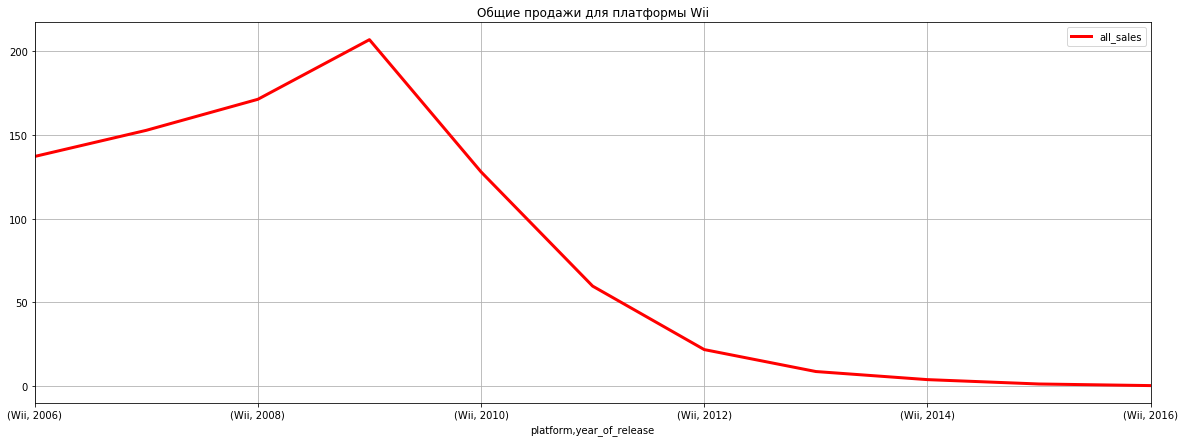

In [26]:
df_platform.query('platform == "Wii"').plot(figsize=(20, 7), grid=True, color="red", 
                                            linewidth=3, title='Общие продажи для платформы Wii')

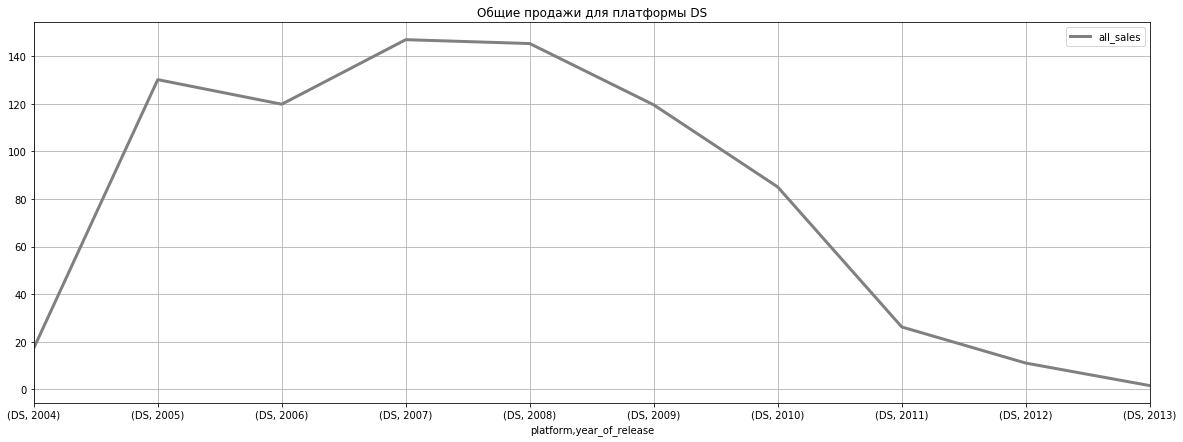

In [27]:
df_platform.query('platform == "DS"').plot(figsize=(20, 7), grid=True, color="grey", 
                                          linewidth=3, title='Общие продажи для платформы DS')

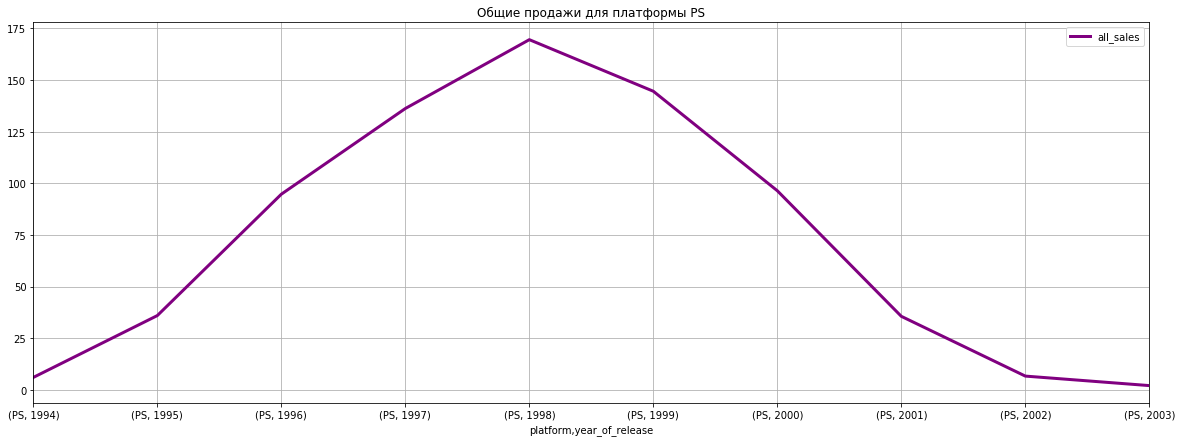

In [28]:
df_platform.query('platform == "PS"').plot(figsize=(20, 7), grid=True, color="purple", 
                                           linewidth=3, title='Общие продажи для платформы PS')

Проанализировав распределения общих продаж по годам для шести самых круных игровых платформ, можем сделать вывод о том что средний срок актуальности игровой платформы составляет 7 лет, после этого срока наблюдается резкое спад доходов от продаж, что является слдествием снижения потребления контента пользователями и выпуска контента производителми игр.

#### Шаг 3.3

Возьмем данные за соответствующий актуальный период. Актуальный период определим основываясь на полученых ранее данных. Построить прогноз на 2017 год поможем понимание жизненного цикла и срока актуальности платформ. Принимая во внимания сделаные ранее выводы, имеет смысл опрерировать велечиной в половину срока актуальности платформы, поэтому примем в качестве актуального периода - 4 года.

In [29]:
df = df.query('year_of_release >= 2012')

Сделаем выборку за 4 предидущих года, игры выпущенные ранее учитывать не будем.

#### Шаг 3.4

Определим какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.

In [30]:
df_platform_sales = df.pivot_table(index=['platform', 'year_of_release'], values='all_sales', aggfunc='sum')

In [31]:
df_platform_2014 = df_platform_sales.query('year_of_release == 2014').sort_values(by = 'all_sales', ascending=False)

df_platform_2014['market_part_%'] = (
    (df_platform_2014['all_sales']/df_platform_2014['all_sales'].sum())*100).round()

df_platform_2014.sort_values(by = 'market_part_%', ascending=False)

,,all_sales,market_part_%
platform,year_of_release,,
PS4,2014,100.00,30.0
XOne,2014,54.07,16.0
PS3,2014,47.76,14.0
3DS,2014,43.76,13.0
X360,2014,34.74,10.0
WiiU,2014,22.03,7.0
PC,2014,13.28,4.0
PSV,2014,11.90,4.0
Wii,2014,3.75,1.0


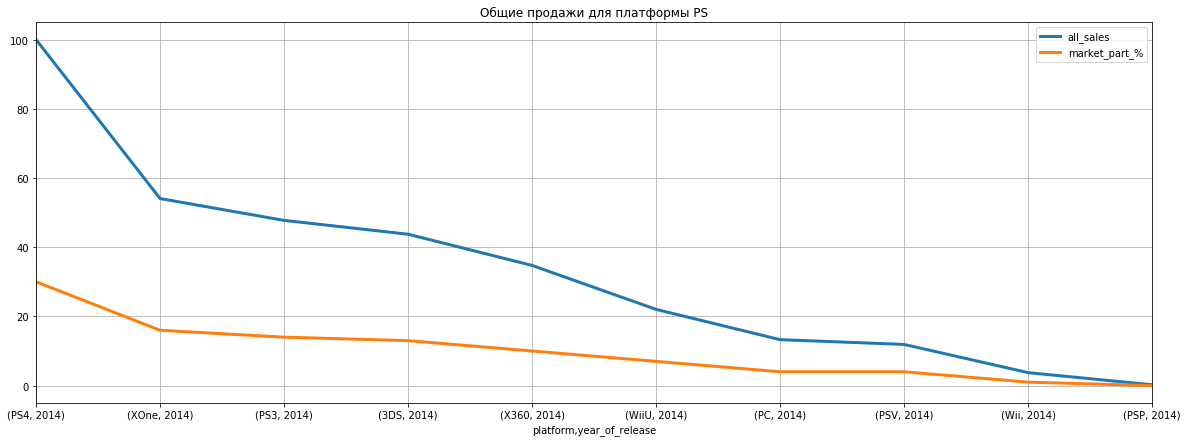

In [32]:
df_platform_2014.plot(figsize=(20, 7), grid=True,
                                           linewidth=3, title='Общие продажи для платформы PS')

In [33]:
df_platform_2015 = df_platform_sales.query('year_of_release == 2015').sort_values(by = 'all_sales', ascending=False)

df_platform_2015['market_part_%'] = (
    (df_platform_2015['all_sales']/df_platform_2015['all_sales'].sum())*100).round()

df_platform_2015.sort_values(by = 'market_part_%', ascending=False)

,,all_sales,market_part_%
platform,year_of_release,,
PS4,2015,118.90,44.0
XOne,2015,60.14,22.0
3DS,2015,27.78,10.0
PS3,2015,16.82,6.0
WiiU,2015,16.35,6.0
X360,2015,11.96,4.0
PC,2015,8.52,3.0
PSV,2015,6.25,2.0
Wii,2015,1.14,0.0


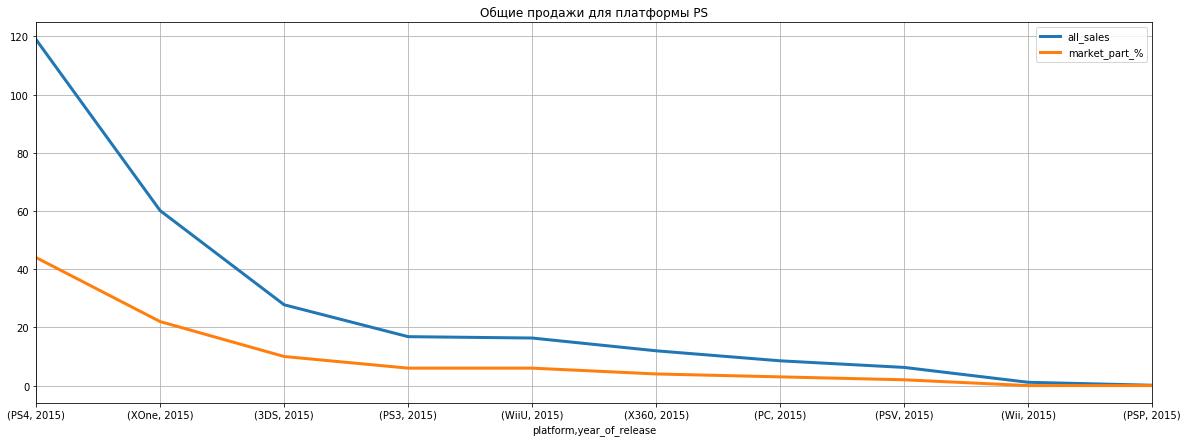

In [34]:
df_platform_2015.plot(figsize=(20, 7), grid=True,
                                           linewidth=3, title='Общие продажи для платформы PS')

In [35]:
df_platform_2016 = df_platform_sales.query('year_of_release == 2016').sort_values(by = 'all_sales', ascending=False)

df_platform_2016['market_part_%'] = (
    (df_platform_2016['all_sales']/df_platform_2016['all_sales'].sum())*100).round()

df_platform_2016.sort_values(by = 'market_part_%', ascending=False)

,,all_sales,market_part_%
platform,year_of_release,,
PS4,2016,69.25,53.0
XOne,2016,26.15,20.0
3DS,2016,15.14,12.0
PC,2016,5.25,4.0
WiiU,2016,4.60,4.0
PSV,2016,4.25,3.0
PS3,2016,3.60,3.0
X360,2016,1.52,1.0
Wii,2016,0.18,0.0


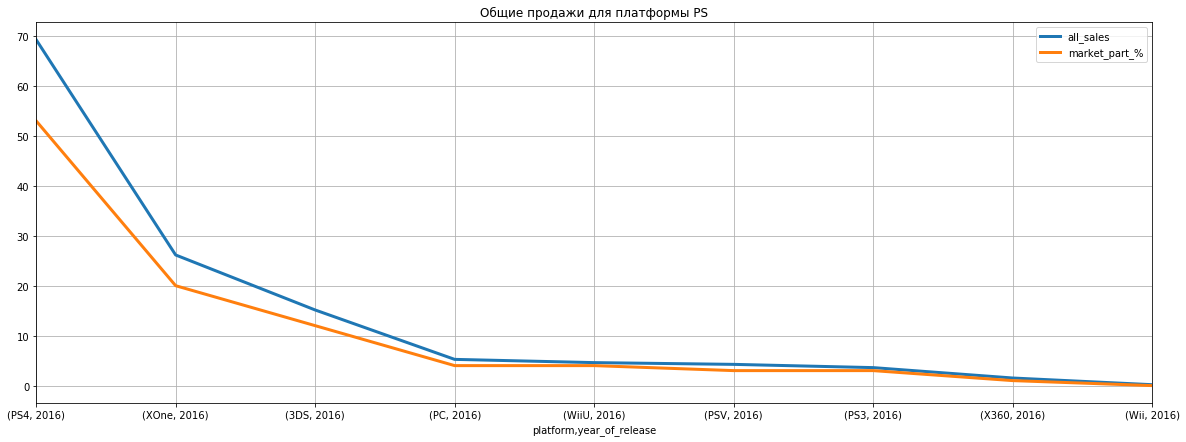

In [36]:
df_platform_2016.plot(figsize=(20, 7), grid=True,
                                           linewidth=3, title='Общие продажи для платформы PS')

На основе анализа данных по объемам продаж на разных платформам за последние три года, можно проследить несколько тенденций:
- В 2016 году наблюдается общий почти двукратный спад продаж, возможно это вызвано тем что находясь в декабре 2016 мы еще не получили данных о продажах за 4ый квартал 2016года, а он как правило для игровой индустрии самый прибыльный, не в последнюю очередь из-за праздничных дней.
- Платформа PS3 планомерно теряет позиции, причина этому достаточно очивидна - укрепление на рынке консоли следующего поколения того же производителя - PS4.
- PS4 укрепляется на позиции лидера, последовательно наращивая долю рынка, можно предположить что такая тенденция продолжится до момента выхода консоли следующего поколения, но в 2017 году этого не планируется, поэтому можно прогназировать дальнейший рост продаж PS4
- Остальные участники рынка достаточно стабильны и удерживают позиции.

#### Шаг 3.5

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [37]:
top_pivot = df.pivot_table(index='name', columns='platform', values='all_sales')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


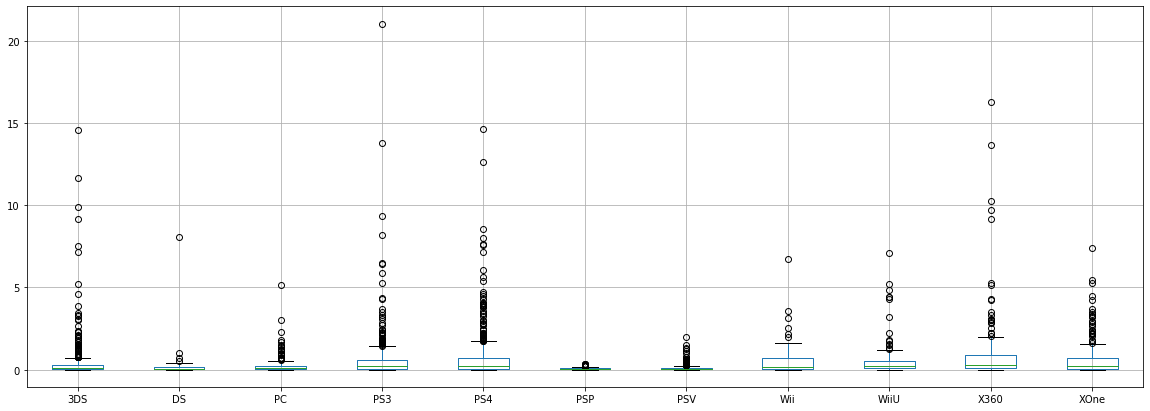

In [38]:
top_pivot.boxplot(figsize=(20, 7))

Попробуем улучшить читаемость графика, убрав аномальные значения.
Проанализируем данные на предмет аномальных значений, оценим их по квантилям.

In [39]:
# Для детального изучения применим метод describe к нашему датафрейму, отдельно конкретизируем процентную детализацию
percetnage =[.10, .85, .90, .95, .99]
top_pivot.describe(percentiles=percetnage)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,396.000000,31.000000,250.00000,492.00000,392.000000,173.000000,411.000000,54.000000,147.000000,292.000000,247.000000
mean,0.491439,0.404839,0.25060,0.58436,0.801378,0.064682,0.119659,0.655000,0.559116,0.810068,0.645020
std,1.387161,1.439245,0.49464,1.46174,1.609456,0.071296,0.203011,1.165447,1.058836,1.712069,1.036139
min,0.010000,0.010000,0.01000,0.01000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
10%,0.020000,0.010000,0.01000,0.02000,0.020000,0.010000,0.010000,0.010000,0.020000,0.030000,0.016000
50%,0.110000,0.050000,0.08000,0.20000,0.200000,0.030000,0.050000,0.180000,0.220000,0.310000,0.220000
85%,0.627500,0.390000,0.46300,0.94000,1.660000,0.122000,0.190000,0.981000,0.786000,1.307000,1.340000
90%,0.935000,0.510000,0.65100,1.24900,2.137000,0.170000,0.300000,1.887000,1.148000,1.709000,1.758000
95%,2.032500,0.855000,0.96000,1.88800,3.910500,0.208000,0.445000,2.733500,2.101000,2.956000,2.872000
99%,7.631000,5.948000,2.06480,6.44180,7.688800,0.325600,1.109000,5.074600,5.064400,9.757700,4.905800


В столбце с данными о продажах консоли PS4 мы видим что лишь 1% от всего объема продаж приходится на значения свыше 7.74, поэтому уберем из датафрейма все значения превышающие 7.74.

In [40]:
top_pivot = top_pivot.query('PS4 <= 7.74')

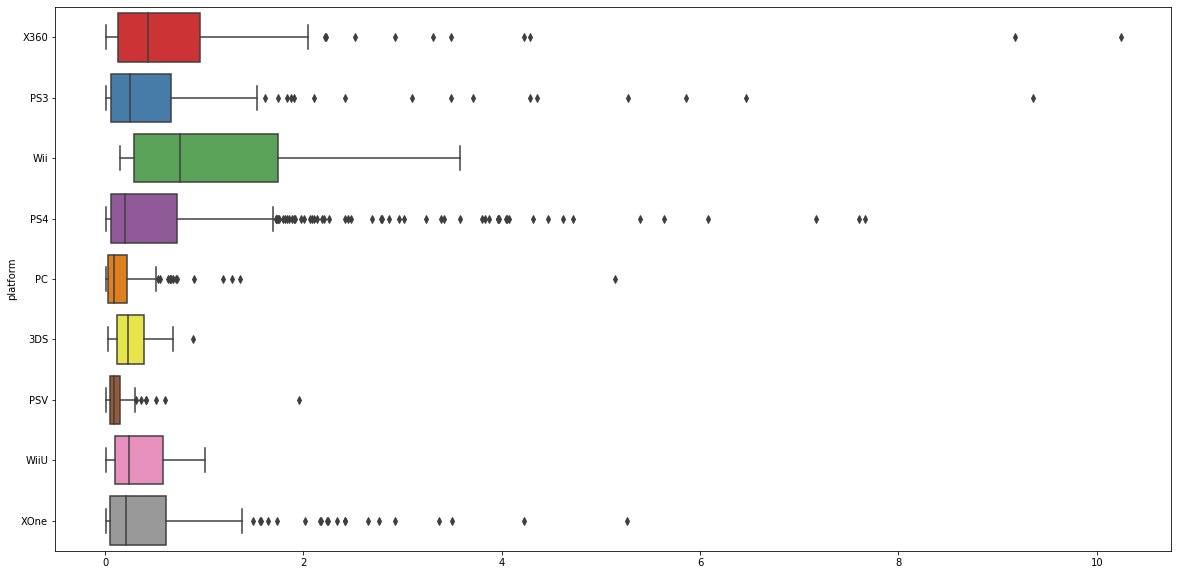

In [41]:
matplotlib.rcParams['figure.figsize'] = 20, 10
order = ["X360", "PS3", "Wii", "PS4", "PC", "3DS", "PSV", "WiiU", "XOne"]
ax = sns.boxplot(data=top_pivot, palette="Set1", orient="h", order=order)

PS4 является безусловным лидером продаж, с самымым выским объемом продаж и средним доходом с одной игры.

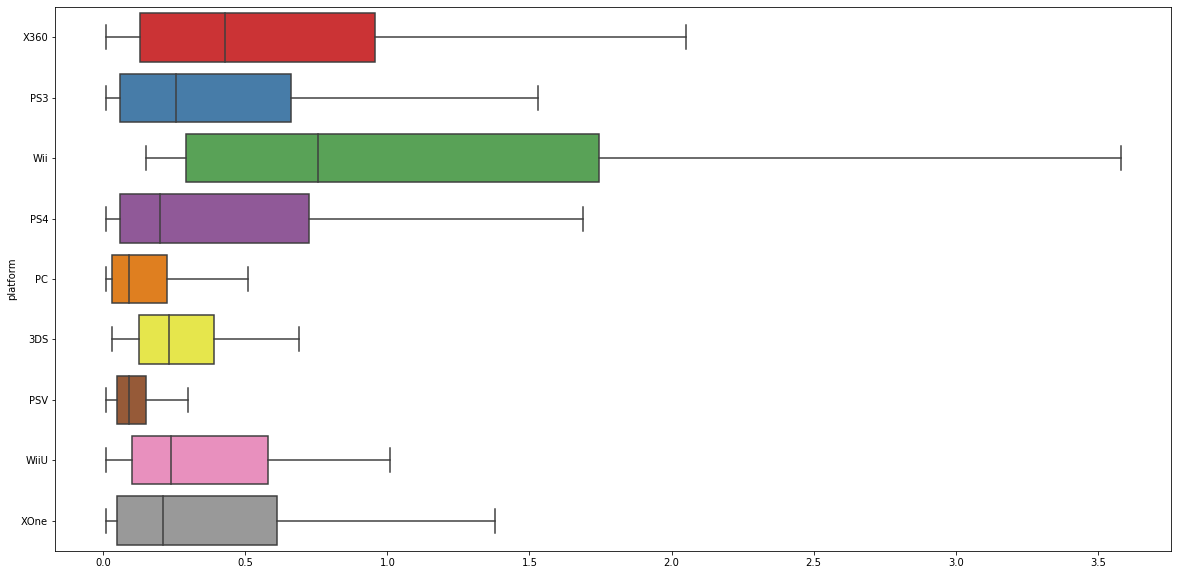

In [42]:
sns.boxplot(data=top_pivot, palette="Set1", orient="h", order=order, showfliers=False)

#### Шаг 3.6

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.

In [43]:
df = df.query('user_score != "tbd"')
df['user_score'] = df['user_score'].astype('float')

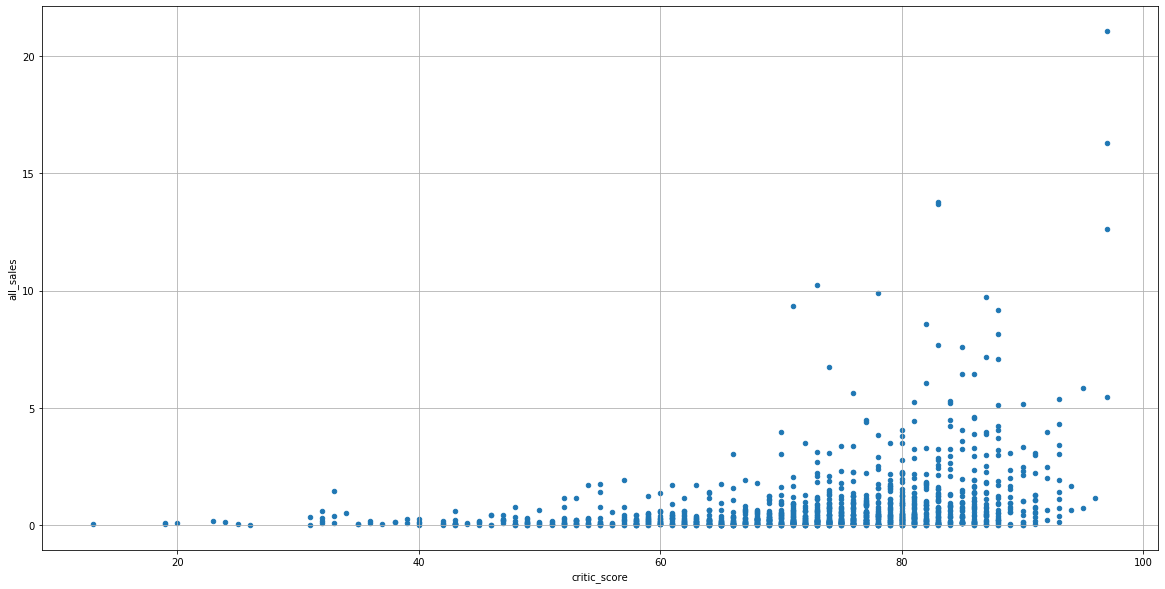

In [44]:
df.plot(x='critic_score', y='all_sales', kind='scatter', grid=True)

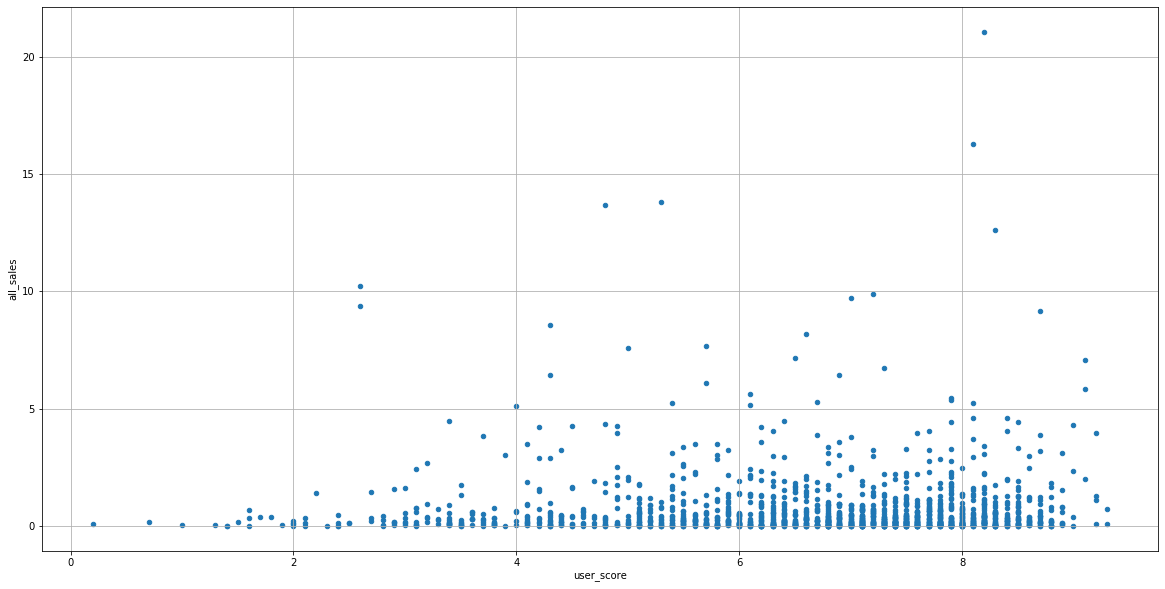

In [45]:
df.plot(x='user_score', y='all_sales', kind='scatter', grid=True)

In [46]:
df['all_sales'].corr(df['critic_score'])

0.30685897099907866

In [47]:
df['all_sales'].corr(df['user_score'])

0.004428817675493266

Отзывы критиков имеют определенную корреляцию с общемировыми продажами, чего совсем нельзя сказать об оценках пользователей.

#### Шаг 3.7

Соотнесем выводы с продажами игр на других платформах.
Для этого посчитаем корреляцию между отзывами и продажами для всех платформ и сравним с результатом для популярной платформы - PS4

In [48]:
other_platform = df.query('platform != "PS4"')

In [49]:
other_platform['all_sales'].corr(other_platform['critic_score'])

0.2831129311085806

In [50]:
other_platform['all_sales'].corr(other_platform['user_score'])

0.009513048660603464

In [51]:
ps4_platform = df.query('platform == "PS4"')

In [52]:
ps4_platform['all_sales'].corr(ps4_platform['critic_score'])

0.4064685741971657

In [53]:
ps4_platform['all_sales'].corr(ps4_platform['user_score'])

-0.031957110204556424

На основе полуенных данных можно сделать следующие выводы:
- Корреляция между оценками критиков и продажами для PS4 выше чем для остальных платформ, это говорит о более выском качестве аналитики для продуктов этой платформы
- Корреляция между оценками пользователей и общими продажами попрежнему около нулевая, для всех типов платформ и для PS4 в частности. К сожелению субъективные оценочные суждения части пользователей расходятся с мнением рынка. Причиной тому может быть тот факт, что оценки формирмирует лишь небольшая и довольно узкая группа пользователей, чье мнение, возможно ввиду возраста или социальных обстоятельств, стоит особняком от мнения основной массы польтзователей, которое и сказывается на продажах. 

#### Шаг 3.8

Посмотрим на общее распределение игр по жанрам. Ответим на вопрос - что можно сказать о самых прибыльных жанрах? Определим выделяются ли жанры с высокими и низкими продажами?

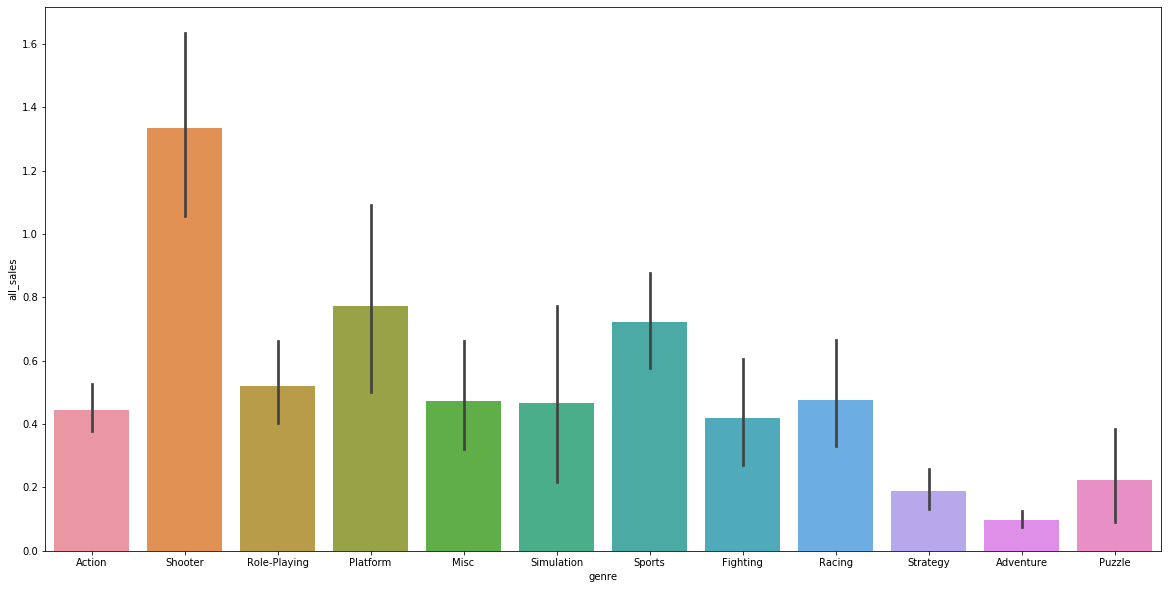

In [54]:
ax = sns.barplot(x="genre", y="all_sales", data=df)

Безусловным лидером продаж среди жанров являются шутеры. Аутсайдерами стали жанры стратегий и приключений. Разница между общими продажами жанрового лидера и аутсайдера более чем десятикратная, что может говорить о том что жанр игры имеет немаловажное значение при определении комерческого успеха продукта.

## <span style="color:orange">Что можно улучшить<span>
Имеет смысл отсортировать диаграмму - восприятие улучшится

### Шаг 4. Составьте портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP)

In [55]:
df.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
genre,,,
Action,157.51,52.33,176.39
Adventure,8.89,8.24,8.64
Fighting,10.77,9.41,19.73
Misc,24.84,12.86,36.90
Platform,20.91,8.63,25.15
Puzzle,1.29,2.14,1.06
Racing,27.19,2.47,17.13
Role-Playing,48.53,65.44,64.00
Shooter,113.33,9.22,144.64


Жанровый портрет складывается следующий:
- Любимый жанр европейцев - Action
- Любимый жанр японцев - Role-Playing
- Любимый жанр американцев - Shooter	

In [56]:
na = df.groupby('platform')\
    .agg({'na_sales':'sum'})\
    .sort_values(by='na_sales', ascending=False)\
    .reset_index()\
    .rename(columns={'platform':'na_platform'})
eu = df.groupby('platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).reset_index()\
    .rename(columns={'platform':'eu_platform'})
jp = df.groupby('platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).reset_index()\
    .rename(columns={'platform':'jp_platform'})

pd.concat([na, eu, jp], axis=1)

,na_platform,na_sales,eu_platform,eu_sales,jp_platform,jp_sales
0,X360,139.16,PS4,141.09,3DS,87.68
1,PS4,108.62,PS3,106.26,PS3,34.92
2,PS3,103.10,X360,74.02,PSV,20.93
3,XOne,92.77,XOne,51.43,PS4,15.96
4,3DS,54.65,3DS,41.64,WiiU,13.01
5,WiiU,37.90,PC,37.67,PSP,10.29
6,PC,19.12,WiiU,24.97,DS,3.72
7,Wii,16.06,PSV,11.21,Wii,3.33
8,PSV,10.97,Wii,10.21,X360,1.56
9,DS,4.35,DS,2.58,XOne,0.34


Самая популярная платформа у европейцев - PS4, жителей северной америки - X360, а у японцев с большим отрывом лидирует - 3DS.

In [57]:
df.pivot_table(index='name', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
name,,,
Beyblade Burst,0.00,0.03,0.00
Fire Emblem Fates,0.23,0.52,0.81
Frozen: Olaf's Quest,0.53,0.00,0.48
Haikyu!! Cross Team Match!,0.00,0.04,0.00
Tales of Xillia 2,0.12,0.45,0.20
...,...,...,...
Zumba Fitness: World Party,0.05,0.00,0.17
Zyuden Sentai Kyoryuger: Game de Gaburincho!!,0.00,0.05,0.00
[Prototype 2],0.55,0.00,0.91


In [58]:
na = df.groupby('name')\
    .agg({'na_sales':'sum'})\
    .sort_values(by='na_sales', ascending=False)\
    .reset_index()\
    .rename(columns={'name':'na_top_game'})
eu = df.groupby('name').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).reset_index()\
    .rename(columns={'name':'eu_top_game'})
jp = df.groupby('name').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).reset_index()\
    .rename(columns={'name':'jp_top_game'})

pd.concat([na, eu, jp], axis=1).head()

,na_top_game,na_sales,eu_top_game,eu_sales,jp_top_game,jp_sales
0,Grand Theft Auto V,23.84,Grand Theft Auto V,23.42,Animal Crossing: New Leaf,4.39
1,Call of Duty: Ghosts,14.94,FIFA 15,12.02,Pokemon X/Pokemon Y,4.35
2,Call of Duty: Black Ops II,14.08,FIFA 16,11.09,Monster Hunter 4,3.44
3,Call of Duty: Black Ops 3,12.25,FIFA 14,10.96,Super Smash Bros. for Wii U and 3DS,3.24
4,Minecraft,11.28,Call of Duty: Black Ops II,10.84,Yokai Watch 2 Ganso/Honke,3.18


Любимые игры для регионов тоже различаются:
- В америке самой продаваемой игрой стала Grand Theft Auto V  
- В европе лидируют футбольные симуляторы, больше всего продаж так же у Grand Theft Auto V
- У японцев же наиболее популярна игра другого жанра, наиболее продаваемым стал RPG симулятор реальной жизни Animal Crossing: New Leaf

In [59]:
na = df.groupby('genre')\
    .agg({'na_sales':'sum'})\
    .sort_values(by='na_sales', ascending=False)\
    .reset_index()\
    .rename(columns={'genre':'na_genre'})
eu = df.groupby('genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).reset_index()\
    .rename(columns={'genre':'eu_genre'})
jp = df.groupby('genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).reset_index()\
    .rename(columns={'genre':'jp_genre'})

In [60]:
pd.concat([na, eu, jp], axis=1)

,na_genre,na_sales,eu_genre,eu_sales,jp_genre,jp_sales
0,Action,176.39,Action,157.51,Role-Playing,65.44
1,Shooter,144.64,Shooter,113.33,Action,52.33
2,Sports,81.13,Sports,68.69,Misc,12.86
3,Role-Playing,64.00,Role-Playing,48.53,Simulation,10.35
4,Misc,36.90,Racing,27.19,Fighting,9.41
5,Platform,25.15,Misc,24.84,Shooter,9.22
6,Fighting,19.73,Platform,20.91,Platform,8.63
7,Racing,17.13,Simulation,14.31,Adventure,8.24
8,Adventure,8.64,Fighting,10.77,Sports,7.77
9,Simulation,7.75,Adventure,8.89,Strategy,2.88


### Шаг 5. Проверим гипотезы

#### Проверим гипотезу: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые

Используем в качестве нулевой - гипотезу средние пользовательские рейтинги платформ Xbox One и PC равны.
Альтернативной гипотезой будем считать утверждение о том что cредние пользовательские рейтинги платформ Xbox One и PC различаются.

In [61]:
df_xbox = df.query('platform == "XOne"')

In [62]:
df_pc = df.query('platform == "PC"') 

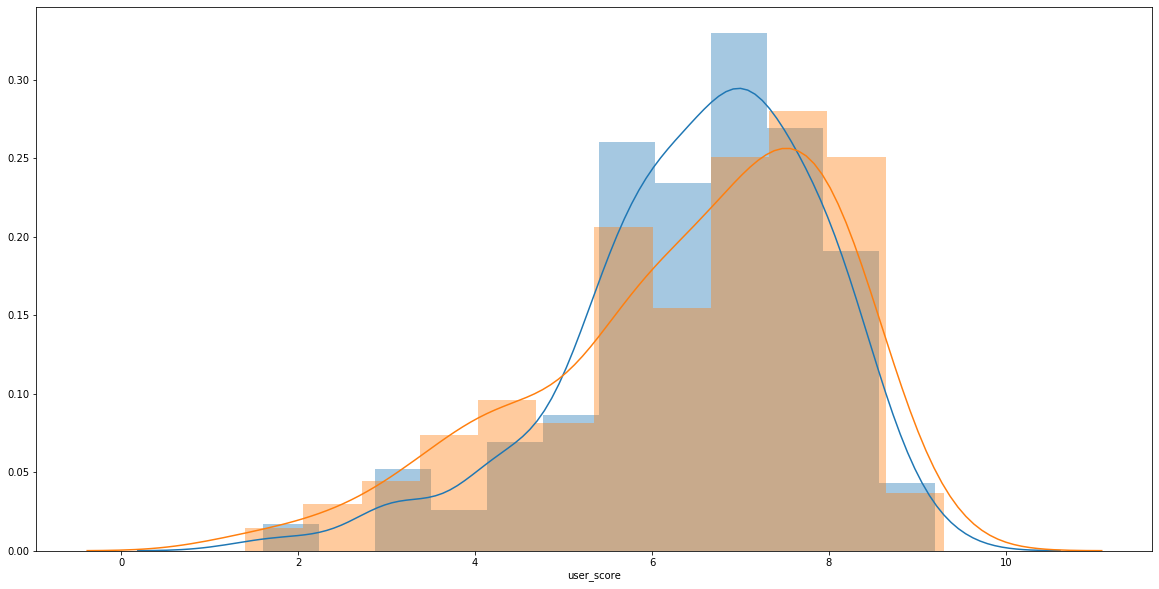

In [63]:
sns.distplot(df_xbox['user_score'], bins=12)
sns.distplot(df_pc['user_score'], bins=12)

 Проанализировав гистограммы можно сделать вывод о том что кривые распределений не являются непрерывнымине - не имеют правильной парабалической формы, наблюдается перекос вправо, а распределние вероятностей в свою очередь, не является нормальным. 

In [64]:
# Так как распределение не нормально напишем функцию проверяющую равенство средних с помощью теста Манна-Уитни
u_alpha = .01 # Зададим критический уровень статистической зависмости в 1%
u_results = st.mannwhitneyu(df_xbox['user_score'], 
                            df_pc['user_score'], 
                            alternative='two-sided')
print('p-value: {:.10f}'.format(u_results.pvalue))
if u_results.pvalue < u_alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.1594946036
Не получилось отвергнуть нулевую гипотезу


In [65]:
df_pc['user_score'].mean()

6.428640776699029

In [66]:
df_xbox['user_score'].mean()

6.521428571428572

В результате проведения теста Манна-Уитни подтвердилась гипотеза о том что средние пользовательские рейтинги платформ Xbox One и PC равны, о чем говорит значение p-value. Полученое в результате наших вычислений значение p-value незначительно и можно считать пользовательские рейтинги платформ Xbox One и PC равны.

#### Проверим гипотезу: cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Используем в качестве нулевой - гипотезу о равестве средних значений пользовательских рейтингов жанров Action и Sports.
Альтернативной гипотезой будем считать утверждение о том что средние пользовательские рейтинги жанров Action и Sports различаются.

In [67]:
df_action = df.query('genre == "Action"')

In [68]:
df_sports = df.query('genre == "Sports"') 

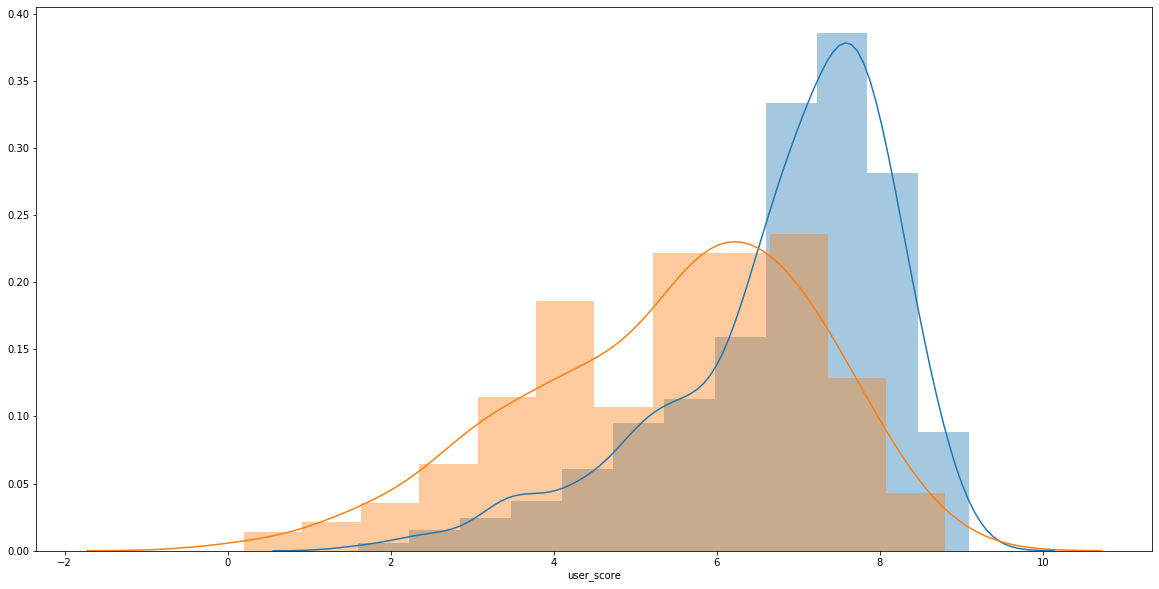

In [69]:
sns.distplot(df_action['user_score'], bins=12)
sns.distplot(df_sports['user_score'], bins=12)

 Проанализировав гистограммы можно сделать вывод о том что кривые распределений не являются непрерывными - не имеют правильной парабалической формы, наблюдается перекос вправо, а распределние вероятностей в свою очередь, не является нормальным. 

In [70]:
# Так как распределение не нормально напишем функцию проверяющую равенство средних с помощью теста Манна-Уитни
u_alpha = .01
u_results = st.mannwhitneyu(df_action['user_score'], 
                            df_sports['user_score'], 
                            alternative='two-sided')
print('p-value: {:.10f}'.format(u_results.pvalue))
if u_results.pvalue < u_alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.0000000000
Отвергаем нулевую гипотезу


In [71]:
df_sports['user_score'].mean()

5.455897435897437

In [72]:
df_action['user_score'].mean()

6.825047801147227

Нулевая гипотеза отвергнута о равестве средних значений пользовательских рейтингов жанров Action и Sports. Cредние значения пользовательских рейтингов жанров различаются, о чем говорит и тест Манна-Уитни и найденые классические средние значения. 

### Шаг 6. Общий вывод

На основе проанализированных за актуальный период данных, можно сделать следующие прогнозы продаж на предстоящий год:
- Наиболее популярной консолью будет PS4, ее доля рынка будет только рости, в текущем модельном ряду отсутствуют предпосылки к смене данной тенденции, смена модельного ряда исходя из расчитаного среднего жизненного цикла консолей произойдет только в 2020-2021 годах.
- Самый популярный жанр - Шутер, он же наиболее популярен на самом крупном рынке - северо-американском. Перспективы же окупаемости выскобюджетных стратегий весьма неоднозначны, в этом жанре необходимо наиболее внимательно подходить к финансовым оценкам.
- Число выпущенных игр снизится. Наблюдается отчетливая тенденция к снижению количества выпуска игры. Это объяснятеся усилением конкуренции, ростом качества и как следствие ростом сложности производства игровых продуктов.
- Рейтинги критиков можно принимать во внимание, так как они в достаточной степени коррелируют с объемами продаж.
- Жанровые предпочтения у жителей разных регионов различаются, наиболее обособленные вкусовые предпочтения выделяются на японском рынке.
